# Canada Temperature Prediction

## Table of Contents

1. [Importing Python Libraries and Reading the Data](#Importing-Python-Libraries-and-Reading-the-Data)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Modelling](#Modelling)
4. [The Script](#The-Script)

## Importing Python Libraries and Reading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta
# import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('Data/GlobalLandTemperaturesByCountry.csv', parse_dates=['dt'])
df = df[df['Country']=='Canada']
df.rename(columns={'dt':'Date'}, inplace=True)
df = df[df['Date']>='1980-01-01'] # I am only interested in data since 1980
df = df.sort_values('Date') # make sure data is sorted
df.set_index('Date', inplace=True)
display(df.shape)
display(df.head())

(405, 3)

,AverageTemperature,AverageTemperatureUncertainty,Country
Date,,,
1980-01-01,-22.529,0.273,Canada
1980-02-01,-18.497,0.232,Canada
1980-03-01,-14.981,0.218,Canada
1980-04-01,-4.651,0.398,Canada
1980-05-01,4.375,0.223,Canada


In [4]:
print(df.tail(1))

            AverageTemperature  AverageTemperatureUncertainty Country
Date                                                                 
2013-09-01               7.922                          2.222  Canada


## Exploratory Data Analysis

Let's first start with some descriptive statistics

In [5]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,405.000000,405.000000
mean,-4.019440,0.244659
std,12.549379,0.112596
min,-27.335000,0.123000
25%,-15.918000,0.204000
50%,-3.362000,0.232000
75%,8.211000,0.267000
max,14.796000,2.222000


Let's see what the data looks like over time

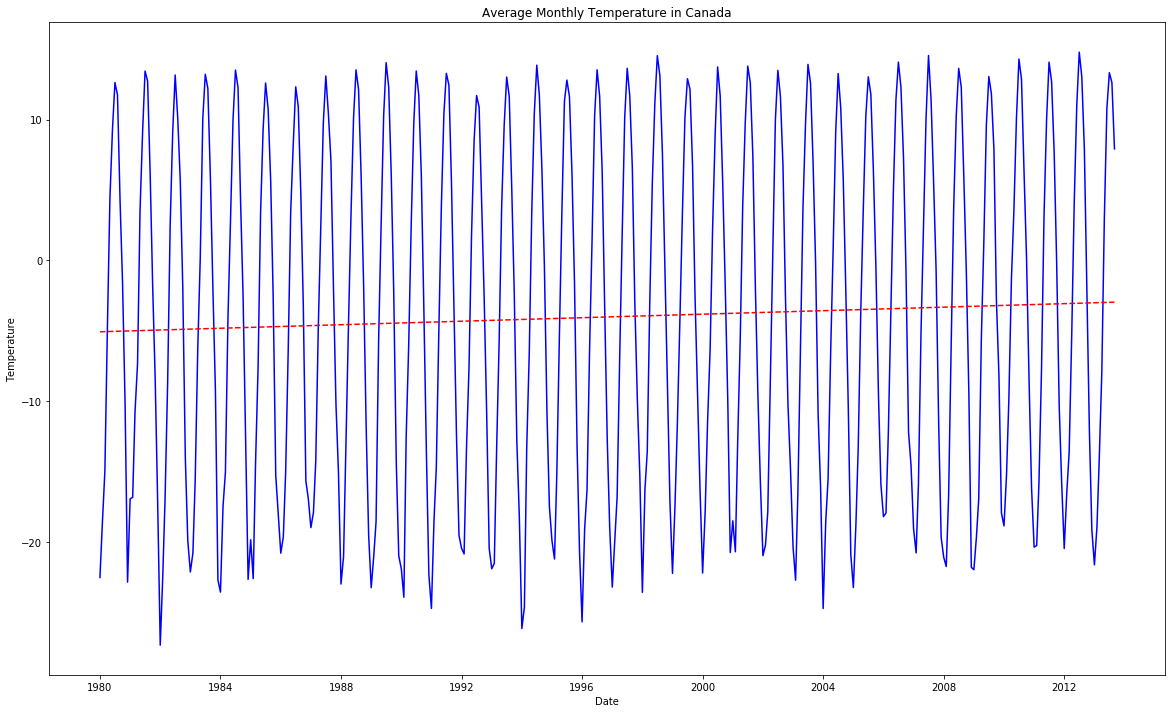

In [6]:
plt.figure(figsize=(20,12))
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Average Monthly Temperature in Canada')
plt.plot(df.index, df['AverageTemperature'], color='b')

# add trendline
z = np.polyfit(df.reset_index().index, df['AverageTemperature'], 1)
p = np.poly1d(z)
plt.plot(df.index, p(df.reset_index().index),"r--")

Decompose to remove monthly seasonality

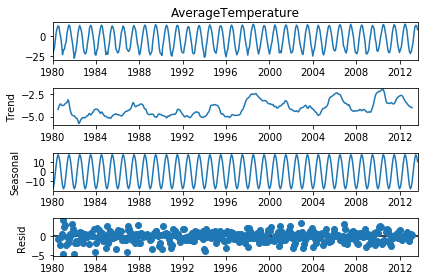

In [7]:
decomposition = seasonal_decompose(df['AverageTemperature'], period=12)
decomposition.plot()
plt.show()

So we have seasonal, time dependent (increasing) data. This will be important for choosing the model.

## Modelling

Since we have seasonal, time-dependent data, I am going to use a Seasonal Autoregressive Integrated Moving Average (SARIMA) model.

Split data into train & test.

In [8]:
def time_series_train_test_split_y(df, test_date_start):
    """Splits the time series dataframe, df, into train and test dataframes 
    for y only at the specified start date for testing, test_date_start.
    The function returns all of y, y_train, y_test.
    """
    test_date_cutoff = datetime.strptime(test_date_start, '%Y-%m-%d')
    train_date_cutoff = test_date_cutoff - timedelta(1)
    
    y = df['AverageTemperature']
    y_train = y.loc[:train_date_cutoff]
    y_test = y.loc[test_date_cutoff:]
    
    return y, y_train, y_test

y, y_train, y_test = time_series_train_test_split_y(df, '2010-01-01')

Determine the optimal parameters for (p,d,q),(P,D,Q,m). Clearly m=12. Will also assume d=1 and D=1 based on our earlier observations.

In [9]:
def optimize_sarima_parameters(y, **kwargs):
    """Returns optimized (p,d,q),(P,D,Q,m) parameters based on specified test and metric.
    Optimization will be done on the full dataset (train and test).
    It is assumed that d=1, D=1, m=12, and seasonal=True."""
    
    opt = pm.auto_arima(y, d=1, D=1, m=12, seasonal=True, **kwargs)
    return opt.get_params()['order'], opt.get_params()['seasonal_order']

opt_order, opt_seasonal_order = optimize_sarima_parameters(y,
                                                           trend='c', start_p=0, start_q=0, test='adf', 
                                                           max_order=6, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1908.930, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1715.147, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1799.741, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1696.766, Time=1.04 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.74 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.29 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1797.656, Time=0.92 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1675.354, Time=1.38 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1694.141, Time=0.53 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=5.45 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.80 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1667.867, Time=1.30 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=1684.8

Train model.

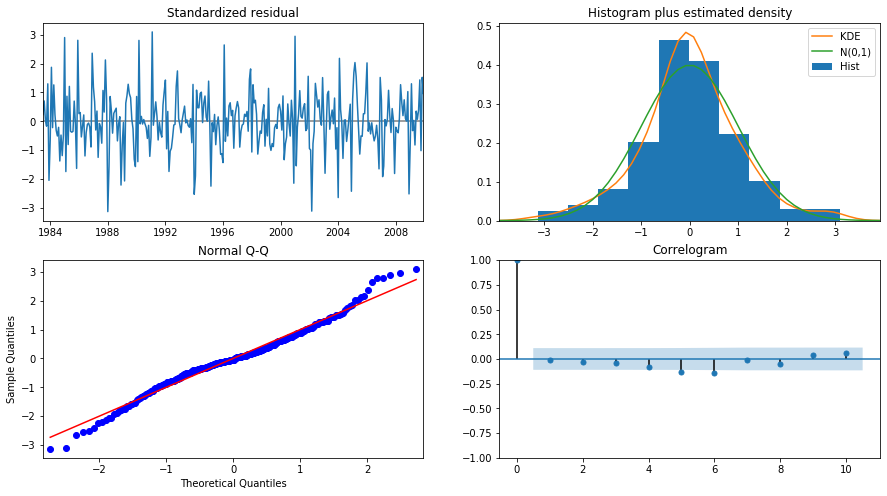

In [10]:
def train_sarima_model(y_train, order, seasonal_order, plot_diagnostics=True, **kwargs):
    """Trains a SARIMAX model based on the training data, y_train, 
    SARIMA parameters, order and seasonal_order, and other keywords.
    Will also return a diagnostics plot of the model if plot_diagnostics=True."""
    
    # Fit Model
    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order, **kwargs)
    results = model.fit()

    # Plot diagnostics, if true
    if plot_diagnostics:
        results.plot_diagnostics(figsize=(15,8))
        plt.show()
    
    return results
    
results = train_sarima_model(y_train=y_train, order=opt_order, seasonal_order=opt_seasonal_order, 
                             plot_diagnostics=True,
                             trend='c', enforce_stationarity=False, enforce_invertibility=False)

Examine model on test dataset.

Root Mean Squared Error = 2.2865373042646593
R^2 = 0.9684695046107379


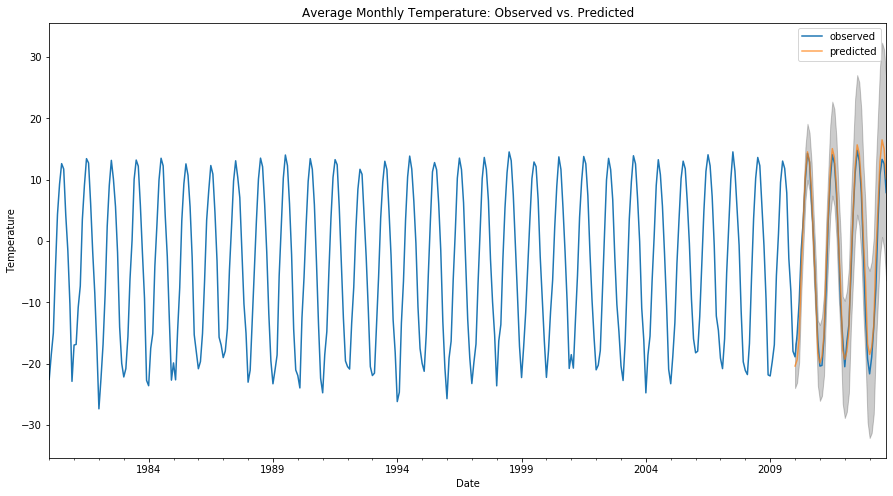

In [11]:
def test_sarima_model(y, y_test, results, **kwargs):
    """Use the model, results, to make prediction on the test dataset, y_test.
    Prints out the root mean squared error, the R^2 value and a graph of 
    observed vs. predicted average monthly temperature for these predictions."""
    
    # Get predictions
    pred = results.get_prediction(start=y_test.index.min(), end=y_test.index.max(), **kwargs)
    y_pred = pred.predicted_mean
    pred_ci = pred.conf_int()

    # Calculate some metrics and print them out
    rmse = ((y_pred - y_test) ** 2).mean() ** 0.5
    print('Root Mean Squared Error =', rmse)
    
    r2 = r2_score(y_pred, y_test)
    print('R^2 =', r2)
    
    # Graph
    ax = y.plot(label='observed')
    y_pred.plot(ax=ax, label='predicted', alpha=.7, figsize=(15, 8))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    plt.title('Average Monthly Temperature: Observed vs. Predicted')
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature')
    plt.legend()
    plt.show()
    
test_sarima_model(y=y, y_test=y_test, results=results, dynamic=True)

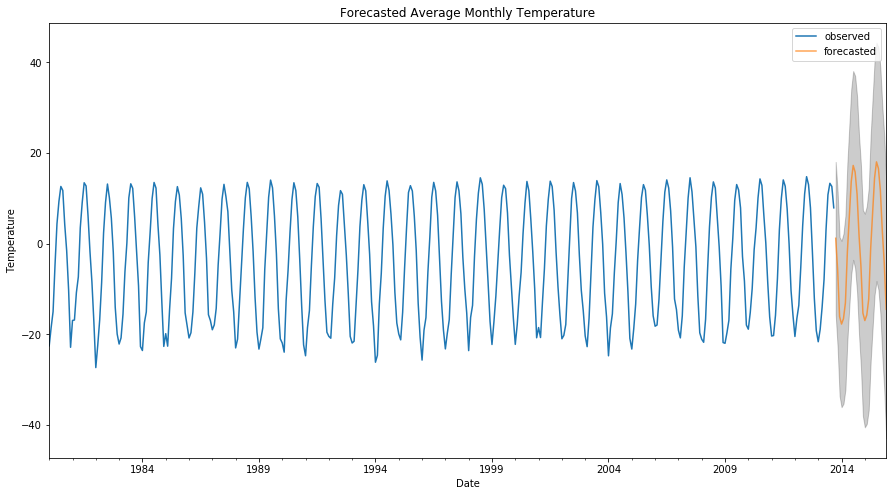

AverageTemperature,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2013-10-01,1.20,8.60,-15.66,18.06
2013-11-01,-5.82,8.77,-23.01,11.36
2013-12-01,-16.08,8.94,-33.59,1.44
2014-01-01,-17.73,9.36,-36.08,0.63
2014-02-01,-16.55,9.57,-35.30,2.21
2014-03-01,-13.02,9.79,-32.21,6.16
2014-04-01,-1.90,10.00,-21.49,17.70
2014-05-01,5.96,10.20,-14.03,25.95
2014-06-01,13.71,10.42,-6.71,34.12


In [12]:
def forecast_temperature(y, results, end_date, **kwargs):
    """Uses the SARIMAX model, results, to forecast the average monthly temperature
    from the end of the dataset, y, until the specified end date, end_date.
    Returns a table containing predicted mean, standard error, and the lower and upper 
    95% confidence interval bounds.
    Function will also print out a graph containing the forecasted average monthly temperature."""
    
    # Forecast
    forecast = results.get_prediction(start=(y.index.max() + timedelta(1)),
                                      end=end_date,
                                      **kwargs)
    y_forecast = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Graph forecast
    ax = y.plot(label='observed')
    y_forecast.plot(ax=ax, label='forecasted', alpha=.7, figsize=(15, 8))
    ax.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:, 0],
                    forecast_ci.iloc[:, 1], color='k', alpha=.2)
    plt.title('Forecasted Average Monthly Temperature')
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature')
    plt.legend()
    plt.show()
    
    # Generate forecast table
    forecast_table = forecast.summary_frame()
    forecast_table.index.rename('Date',inplace=True)
    forecast_table = round(forecast_table, 2)
    
    return forecast_table
    
forecast_temperature(y=y, results=results, end_date='2015-12-01')

## The Script

In [13]:
%%writefile canada_temperature_prediction.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

def read_and_prepare_dataframe(start_date='1980-01-01'):
    """Function will read the dataset and prepare the dataframe for the forecast model.
    Dataframe will only contain data for Canada beginning at start_date."""
    
    # Read the dataset and rename 'dt' to 'Date'
    df = pd.read_csv('Data/GlobalLandTemperaturesByCountry.csv', parse_dates=['dt'])
    df.rename(columns={'dt':'Date'}, inplace=True)
    
    # Filter for Canada
    df = df[df['Country']=='Canada']
    
    # Filter out data prior to start date
    df = df[df['Date'] >= start_date]
    
    # To ensure data is sorted
    df = df.sort_values('Date')
    
    # Set index to Date and return the final dataframe
    return df.set_index('Date')

def time_series_train_test_split_y(df, test_date_start):
    """Splits the time series dataframe, df, into train and test dataframes 
    for y only at the specified start date for testing, test_date_start.
    The function returns all of y, y_train, y_test.
    """
    test_date_cutoff = datetime.strptime(test_date_start, '%Y-%m-%d')
    train_date_cutoff = test_date_cutoff - timedelta(1)
    
    y = df['AverageTemperature']
    y_train = y.loc[:train_date_cutoff]
    y_test = y.loc[test_date_cutoff:]
    
    return y, y_train, y_test

def optimize_sarima_parameters(y, **kwargs):
    """Returns optimized (p,d,q),(P,D,Q,m) parameters based on specified test and metric.
    Optimization will be done on the full dataset (train and test).
    It is assumed that d=1, D=1, m=12, and seasonal=True."""
    
    opt = pm.auto_arima(y, d=1, D=1, m=12, seasonal=True, **kwargs)
    return opt.get_params()['order'], opt.get_params()['seasonal_order']


def train_sarima_model(y_train, order, seasonal_order, plot_diagnostics=True, **kwargs):
    """Trains a SARIMAX model based on the training data, y_train, 
    SARIMA parameters, order and seasonal_order, and other keywords.
    Will also return a diagnostics plot of the model if plot_diagnostics=True."""
    
    # Fit Model
    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order, **kwargs)
    results = model.fit()

    # Plot diagnostics, if true
    if plot_diagnostics:
        results.plot_diagnostics(figsize=(15,8))
        plt.show()
    
    return results

def test_sarima_model(y, y_test, results, **kwargs):
    """Use the model, results, to make prediction on the test dataset, y_test.
    Prints out the root mean squared error, the R^2 value and a graph of 
    observed vs. predicted average monthly temperature for these predictions."""
    
    # Get predictions
    pred = results.get_prediction(start=y_test.index.min(), end=y_test.index.max(), **kwargs)
    y_pred = pred.predicted_mean
    pred_ci = pred.conf_int()

    # Calculate some metrics and print them out
    rmse = ((y_pred - y_test) ** 2).mean() ** 0.5
    print('Root Mean Squared Error =', rmse)
    
    r2 = r2_score(y_pred, y_test)
    print('R^2 =', r2)
    
    # Graph
    ax = y.plot(label='observed')
    y_pred.plot(ax=ax, label='predicted', alpha=.7, figsize=(15, 8))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    plt.title('Average Monthly Temperature: Observed vs. Predicted')
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature')
    plt.legend()
    plt.show()
    
def forecast_temperature(y, results, end_date, **kwargs):
    """Uses the SARIMAX model, results, to forecast the average monthly temperature
    from the end of the dataset, y, until the specified end date, end_date.
    Returns a table containing predicted mean, standard error, and the lower and upper 
    95% confidence interval bounds.
    Function will also print out a graph containing the forecasted average monthly temperature."""
    
    # Forecast
    forecast = results.get_prediction(start=(y.index.max() + timedelta(1)),
                                      end=end_date,
                                      **kwargs)
    y_forecast = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Graph forecast
    ax = y.plot(label='observed')
    y_forecast.plot(ax=ax, label='forecasted', alpha=.7, figsize=(15, 8))
    ax.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:, 0],
                    forecast_ci.iloc[:, 1], color='k', alpha=.2)
    plt.title('Forecasted Average Monthly Temperature')
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature')
    plt.legend()
    plt.show()
    
    # Generate forecast table
    forecast_table = forecast.summary_frame()
    forecast_table.index.rename('Date',inplace=True)
    forecast_table = round(forecast_table, 2)
    
    return forecast_table
    

def run_forecast(data_start_date='1980-01-01', forecast_end_date='2015-12-01',
                 test_date_start='2010-01-01', test_model=True):
    """Function will call all the necessary functions to run the forecast and return the final table.
    Can specify the start date for the dataset used to train the forecast, the end date for the forecast,
    and the cutoff date for splitting the test data.
    If desired, the function can output the prediciton results from the test data.
    """
    
    # 1. Prepare dataframe.
    df = read_and_prepare_dataframe(start_date=data_start_date)
    
    # 2. Split dataframe into train and test.
    y, y_train, y_test = time_series_train_test_split_y(df=df, test_date_start=test_date_start)
    
    # 3. Optimize parameters.
    opt_order, opt_seasonal_order = optimize_sarima_parameters(y,
                                                               trend='c', start_p=0, start_q=0, test='adf', 
                                                               max_order=6, stepwise=True, trace=False)
    
    # 4. Train SARIMAX model.
    results = train_sarima_model(y_train=y_train, order=opt_order, seasonal_order=opt_seasonal_order, 
                                 plot_diagnostics=False,
                                 trend='c', enforce_stationarity=False, enforce_invertibility=False)
    
    # 5. Test the model (optional).
    if test_model:
        test_sarima_model(y=y, y_test=y_test, results=results, dynamic=True)
    
    # 6. Make the forecast with the model and return the table containing the results.
    table = forecast_temperature(y=y, results=results, end_date=forecast_end_date)
    return table

if __name__ == '__main__':
    forecast_table = run_forecast()
    display(forecast_table)

Writing canada_temperature_prediction.py
